In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Attention, LayerNormalization
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
# Set global random seed
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
index_names = ['unit_number','time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

# Paths to your data files
df_train_path = '/content/drive/MyDrive/CMAPSSDataset/train_FD001.txt'
df_test_path = '/content/drive/MyDrive/CMAPSSDataset/test_FD001.txt'
df_rul_path = '/content/drive/MyDrive/CMAPSSDataset/RUL_FD001.txt'

# Load data
df_train = pd.read_csv(df_train_path, sep='\s+', header=None, names=col_names)
df_test = pd.read_csv(df_test_path, sep='\s+', header=None, names=col_names)
df_rul = pd.read_csv(df_rul_path, sep='\s+', header=None, names=['RUL'])

print("df_train:", df_train.shape)
print("df_test:", df_test.shape)
print("df_rul:", df_rul.shape)

df_train: (20631, 26)
df_test: (13096, 26)
df_rul: (100, 1)


In [ ]:
# Add RUL Column
def add_rul_col(df):
  max_time_cycles = df.groupby('unit_number')['time_cycles'].max()

  new_df_rul = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number', right_index=True)
  new_df_rul['rul'] = new_df_rul['max_time_cycle'] - new_df_rul['time_cycles']
  new_df_rul.drop('max_time_cycle', axis=1, inplace=True)

  return new_df_rul

train_df = df_train.copy()

train_df = add_rul_col(train_df)
train_df.head()

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,rul
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [ ]:
# Sensor Names

sensor_names={}
names_list=[
    'Fan inlet temperature (◦R)', 'LPC outlet temperature (◦R)', 'HPC outlet temperature (◦R)', 'LPT outlet temperature (◦R)',
    'Fan inlet Pressure (psia)', 'bypass-duct pressure (psia)', 'HPC outlet pressure (psia)', 'Physical fan speed (rpm)',
    'Physical core speed (rpm)', 'Engine pressure ratio (P50/P2)', 'HPC outlet Static pressure (psia)', 'Ratio of fuel flow to Ps30 (pps/psia)',
    'Corrected fan speed (rpm)', 'Corrected core speed (rpm)', 'Bypass Ratio', 'Burner fuel-air ratio', 'Bleed Enthalpy', 'Required fan speed',
    'Required fan conversion speed', 'High-pressure turbines Cool air flow', 'Low-pressure turbines Cool air flow' ]
i=1
for x in names_list :
    sensor_names['s_' + str(i)]=x
    i+=1
sensor_names

{'s_1': 'Fan inlet temperature (◦R)',
 's_2': 'LPC outlet temperature (◦R)',
 's_3': 'HPC outlet temperature (◦R)',
 's_4': 'LPT outlet temperature (◦R)',
 's_5': 'Fan inlet Pressure (psia)',
 's_6': 'bypass-duct pressure (psia)',
 's_7': 'HPC outlet pressure (psia)',
 's_8': 'Physical fan speed (rpm)',
 's_9': 'Physical core speed (rpm)',
 's_10': 'Engine pressure ratio (P50/P2)',
 's_11': 'HPC outlet Static pressure (psia)',
 's_12': 'Ratio of fuel flow to Ps30 (pps/psia)',
 's_13': 'Corrected fan speed (rpm)',
 's_14': 'Corrected core speed (rpm)',
 's_15': 'Bypass Ratio',
 's_16': 'Burner fuel-air ratio',
 's_17': 'Bleed Enthalpy',
 's_18': 'Required fan speed',
 's_19': 'Required fan conversion speed',
 's_20': 'High-pressure turbines Cool air flow',
 's_21': 'Low-pressure turbines Cool air flow'}

time_cycles   -0.736241
s_11          -0.696228
s_4           -0.678948
s_15          -0.642667
s_2           -0.606484
s_17          -0.606154
s_3           -0.584520
s_8           -0.563968
s_13          -0.562569
s_9           -0.390102
s_14          -0.306769
s_6           -0.128348
setting_1     -0.003198
setting_2     -0.001948
unit_number    0.078753
s_20           0.629428
s_21           0.635662
s_7            0.657223
s_12           0.671983
rul            1.000000
setting_3           NaN
s_1                 NaN
s_5                 NaN
s_10                NaN
s_16                NaN
s_18                NaN
s_19                NaN
Name: rul, dtype: float64


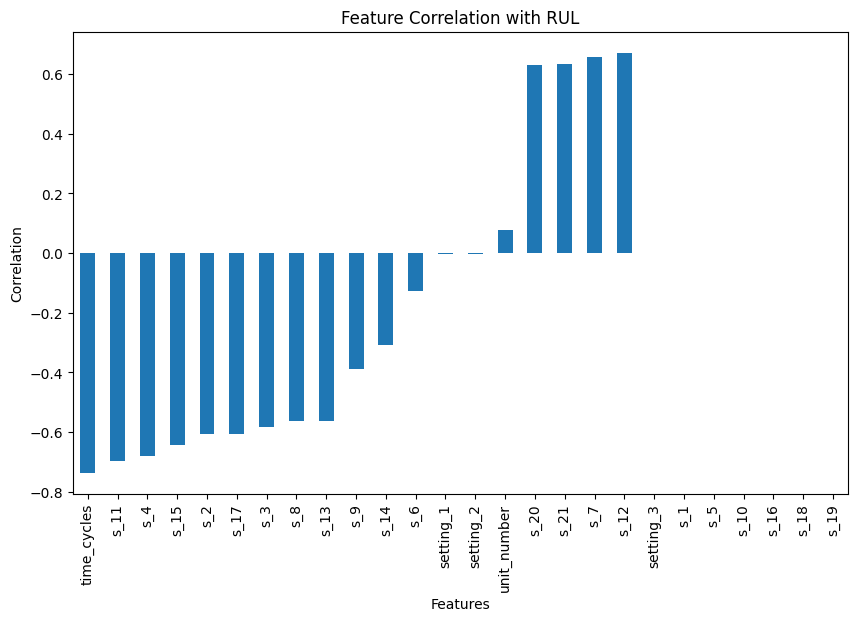

In [ ]:
# Compute the correlation matrix
correlation_matrix = train_df.corr()

# Get correlations with RUL column only
rul_correlation = correlation_matrix['rul'].sort_values()

# Display the correlations
print(rul_correlation)

# Plotting the correlation with RUL
plt.figure(figsize=(10, 6))
rul_correlation.drop('rul').plot(kind='bar')
plt.title('Feature Correlation with RUL')
plt.ylabel('Correlation')
plt.xlabel('Features')
plt.show()

In [ ]:
# Dropping low-correlation features (close to zero or NaN)
low_corr_features = ['s_1', 's_5', 's_10', 's_16', 's_18', 's_19']

train_df_corr = train_df.copy()
X_train_df = train_df_corr.drop(columns=low_corr_features)

df_test_corr = df_test.copy()
X_test_df = df_test_corr.drop(columns=low_corr_features)

print("Dropped features due to low correlation:", low_corr_features)

Dropped features due to low correlation: ['s_1', 's_5', 's_10', 's_16', 's_18', 's_19']


In [ ]:
print("df_train:", X_train_df.shape)
print("df_test:", X_test_df.shape)
print("df_rul:", df_rul.shape)

df_train: (20631, 21)
df_test: (13096, 20)
df_rul: (100, 1)


In [ ]:
# Dropping Index Column and Setting Columns
index_names_2 = ['unit_number']

drop_cols = index_names_2 + setting_names

X_train_df = X_train_df.copy()
X_train_df = X_train_df.drop(columns= drop_cols)

In [ ]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X_train_df, X_train_df['rul'], test_size=0.3, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14441, 17), (6190, 17), (14441,), (6190,))

In [ ]:
# Scaling using Robust Scaler
scaler = RobustScaler()

# drop traget
X_train.drop(columns=['rul'], inplace=True)
X_test.drop(columns= ['rul'], inplace=True)

# scaling
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# converse only the last occurence of each unit to match the lenth of valid
X_valid = X_test_df.copy()
X_valid = X_valid.groupby('unit_number').last().reset_index()
X_valid = X_valid.drop(columns= drop_cols)
X_valid_scaled = scaler.transform(X_valid)

In [ ]:
# Reshape for GRU
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
X_valid_scaled = X_valid_scaled.reshape((X_valid_scaled.shape[0], 1, X_valid_scaled.shape[1]))

In [ ]:
X_train_scaled.shape, X_test_scaled.shape

((14441, 1, 16), (6190, 1, 16))

In [ ]:
# Scaled Dot-Product Attention layer
class ScaledDotProductAttention(Layer):
    def __init__(self, **kwargs):
        super(ScaledDotProductAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.scale = K.sqrt(K.cast(input_shape[-1], K.floatx()))
        super(ScaledDotProductAttention, self).build(input_shape)

    def call(self, x):
        # Split x into query, key, and value
        query = x
        key = x
        value = x

        # Calculate attention scores
        scores = K.batch_dot(query, K.permute_dimensions(key, (0, 2, 1))) / self.scale
        attention_weights = K.softmax(scores, axis=-1)

        # Output the attention-weighted values
        output = K.batch_dot(attention_weights, value)
        return K.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [ ]:
# Build GRU model with enhanced attention
model = Sequential()

# First GRU layer
model.add(GRU(units=256, activation='swish', return_sequences=True, kernel_regularizer=l2(0.01), input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dropout(0.4))

# Second GRU layer
model.add(GRU(units=128, activation='swish', return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))

# Third GRU layer
model.add(GRU(units=64, activation='swish', return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))

# Forth GRU layer
model.add(GRU(units=32, activation='swish', return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))

# First LSTM layer
model.add(LSTM(units=64, activation='swish', return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))

# Attention layer
model.add(ScaledDotProductAttention())

# Flatten the output from attention layer
model.add(layers.Flatten())

# Dense output layer
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

In [ ]:
# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 1, 256)              │         210,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 1, 128)              │         148,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 1, 64)               │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 1, 32)               │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1, 64)               │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ scaled_dot_product_attention         │ (None, 64)                  │               0 │
│ (ScaledDotProductAttention)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 430,209 (1.64 MB)

 Trainable params: 430,209 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Reduce Leaening Rate
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
# Train the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.3,
    callbacks=[lr_scheduler],
    verbose=1
)

Epoch 1/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - loss: 10728.2627 - mae: 80.5101 - val_loss: 1784.4196 - val_mae: 29.6792 - learning_rate: 0.0010
Epoch 2/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 2771.8015 - mae: 37.5607 - val_loss: 1701.9658 - val_mae: 28.3635 - learning_rate: 0.0010
Epoch 3/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 2508.0681 - mae: 35.4288 - val_loss: 1441.3092 - val_mae: 27.2875 - learning_rate: 0.0010
Epoch 4/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - loss: 2403.3955 - mae: 34.3841 - val_loss: 1427.5443 - val_mae: 27.1547 - learning_rate: 0.0010
Epoch 5/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 2240.2830 - mae: 33.3323 - val_loss: 1393.3470 - val_mae: 26.4815 - learning_rate: 0.0010
Epoch 6/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 2128.5181 - mae: 32.3795 - val_loss: 1375.4354 - val_mae: 26.2099 - learning_rate: 0.0010
Epoch 7/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 2061.6545 - mae: 31.8271 -

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step
Predicted RUL values for the test set (last cycles): [178.30133   148.24907    66.036415   89.65859   102.679985  102.84425
 110.62402    68.29851   138.32445   101.516525   78.90039   107.923836
  89.92104   136.3577    145.76779   116.37113    47.262016   61.23474
 102.88256    20.367111   59.15751   163.17035   129.29301    20.212145
 158.48222   115.021034   95.70995    89.912224  101.06046    79.41473
  15.2908     47.84806   138.64381     7.6803885  10.418783   21.279707
  49.424385   38.70955   169.87035    24.705994   53.225426   17.020916
  58.20501   141.78766    60.762978   44.97277   117.27263   123.87787
  19.608112  124.152596   91.88716    28.438946   31.585459  139.95212
 118.98914    16.722519   73.88404    38.477882  144.76865    96.01653
  37.17328    67.270966   54.817368   41.921066  153.20972    14.632238
 141.10695    17.201704  145.7647     87.486496  136.83047    68.65164
 133.75534    83.88305   134.45312    12.2532015  2

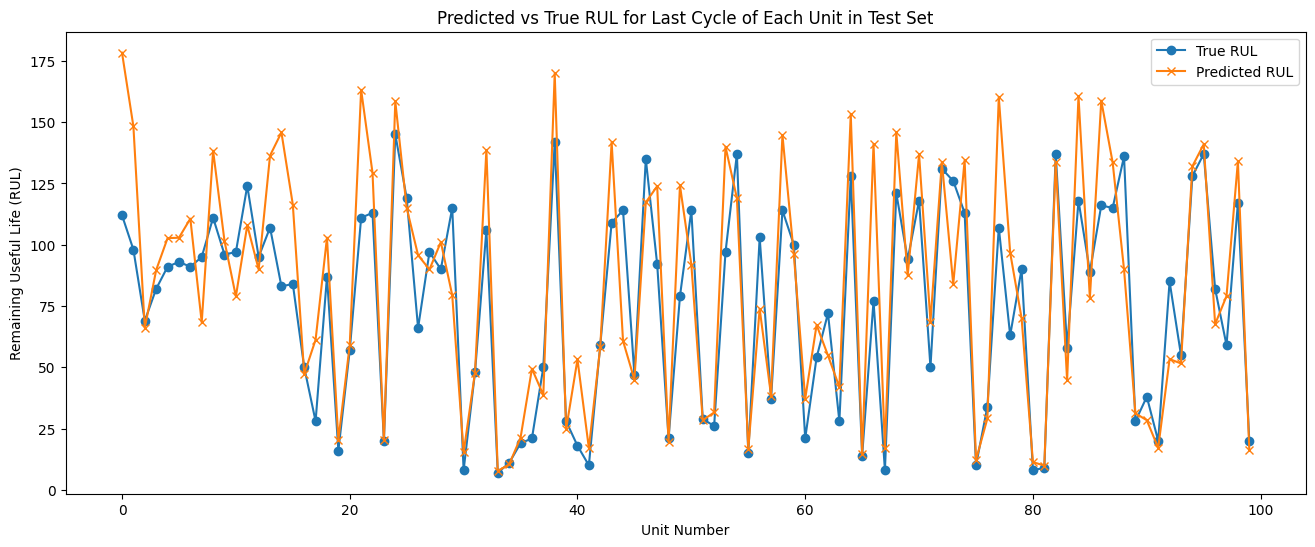

In [ ]:
# Predict RUL for X_valid (last cycle of each unit in the test set)
y_valid_pred = model.predict(X_valid_scaled)

# Flatten predictions to 1D for easier comparison
y_valid_pred = y_valid_pred.flatten()

# Display the predictions and true RUL values
print("Predicted RUL values for the test set (last cycles):", y_valid_pred)
print("True RUL values from df_rul:", df_rul.values.squeeze())

# Evaluate performance using Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE)
from sklearn.metrics import mean_absolute_error, mean_squared_error

true_rul = df_rul.values.squeeze()
mae = mean_absolute_error(true_rul, y_valid_pred)
rmse = np.sqrt(mean_squared_error(true_rul, y_valid_pred))

print(f'Validation MAE: {mae}')
print(f'Validation RMSE: {rmse}')

# Optional: Plotting the Predicted vs True RUL values for better visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.plot(true_rul, label='True RUL', marker='o')
plt.plot(y_valid_pred, label='Predicted RUL', marker='x')
plt.title("Predicted vs True RUL for Last Cycle of Each Unit in Test Set")
plt.xlabel("Unit Number")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test_scaled, y_test)
print(f'Test Loss (MSE): {test_loss}, Test MAE: {test_mae}')

# Predict on the test data
y_pred = model.predict(X_test_scaled)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1233.6600 - mae: 24.3514
Test Loss (MSE): 1254.9122314453125, Test MAE: 24.451641082763672
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
R-squared: 0.7293004989624023
RMSE: 35.212289900498675


In [ ]:
y_valid_pred

array([178.30133  , 148.24907  ,  66.036415 ,  89.65859  , 102.679985 ,
       102.84425  , 110.62402  ,  68.29851  , 138.32445  , 101.516525 ,
        78.90039  , 107.923836 ,  89.92104  , 136.3577   , 145.76779  ,
       116.37113  ,  47.262016 ,  61.23474  , 102.88256  ,  20.367111 ,
        59.15751  , 163.17035  , 129.29301  ,  20.212145 , 158.48222  ,
       115.021034 ,  95.70995  ,  89.912224 , 101.06046  ,  79.41473  ,
        15.2908   ,  47.84806  , 138.64381  ,   7.6803885,  10.418783 ,
        21.279707 ,  49.424385 ,  38.70955  , 169.87035  ,  24.705994 ,
        53.225426 ,  17.020916 ,  58.20501  , 141.78766  ,  60.762978 ,
        44.97277  , 117.27263  , 123.87787  ,  19.608112 , 124.152596 ,
        91.88716  ,  28.438946 ,  31.585459 , 139.95212  , 118.98914  ,
        16.722519 ,  73.88404  ,  38.477882 , 144.76865  ,  96.01653  ,
        37.17328  ,  67.270966 ,  54.817368 ,  41.921066 , 153.20972  ,
        14.632238 , 141.10695  ,  17.201704 , 145.7647   ,  87.4

In [ ]:
true_rul

array([112,  98,  69,  82,  91,  93,  91,  95, 111,  96,  97, 124,  95,
       107,  83,  84,  50,  28,  87,  16,  57, 111, 113,  20, 145, 119,
        66,  97,  90, 115,   8,  48, 106,   7,  11,  19,  21,  50, 142,
        28,  18,  10,  59, 109, 114,  47, 135,  92,  21,  79, 114,  29,
        26,  97, 137,  15, 103,  37, 114, 100,  21,  54,  72,  28, 128,
        14,  77,   8, 121,  94, 118,  50, 131, 126, 113,  10,  34, 107,
        63,  90,   8,   9, 137,  58, 118,  89, 116, 115, 136,  28,  38,
        20,  85,  55, 128, 137,  82,  59, 117,  20])